# Compare - Shanghai Composite Index

- PAPER: [Financial Time Series Forecasting with the Deep Learning Ensemble Model](https://www.mdpi.com/2227-7390/11/4/1054) by He K., et al. 2023

## TODOs

In [1]:
import os
import sys
# Get the current working directory of the notebook
notebook_dir = os.getcwd()

# Add the parent directory to the system path
sys.path.append(os.path.join(notebook_dir, '../tslearn/'))

from collections import namedtuple
from data_loader import build_stock_uts, build_downloaded_stock_uts
from data_plotter import PlotFactory, PlotData, InterpolatePlotter
from ts_models import RandomWalk, ARMA, EvaluationMetric
from time_series import TimeSeriesFactory, TimeSeriesMixin, UnivariateTimeSeries

## Stock Data Analysis with Forecasts

1. Load Raw Data
2. Plot Raw Data
3. Get Descriptive Statistics (ie: mean, median, range, etc) of Raw Data
4. Check Stationarity of Raw Data
5. Plot Autocorrelation and Partial Autocorrelation of Raw Data
6. Get Returns Data
7. Plot Returns Data
8. Get Descriptive Statistics (ie: mean, median, range, etc) of Returns Data
9. Check Stationarity of Returns Data
10. Plot Autocorrelation and Partial Autocorrelation of Returns Data
11. Split Returns Data
12. Initialize Autoregressive `AR(p)` Model
13. Predict Forecasts for Returns Data
14. Plot Actual Forecasts vs Predicted Forecasts for Returns Data
24. Follow-up

### Load Raw Data

In [2]:
# Only grab stocks whose data is available for the entire time period
start_date, end_date = "2010-01-04", "2020-02-07"
Stock = namedtuple("Stock", ["symbol", "name"])
stocks = [
    ("000001.SS", "Shanghai Composite Index")
]
independent_variable = "Close"
# # frequency = 
stocks = [Stock(*s) for s in stocks]
stocks = {s.symbol: build_stock_uts(s.symbol, s.name, independent_variable, start_date=start_date, end_date=end_date, frequency='1d') for s in stocks}

[*********************100%***********************]  1 of 1 completed


In [3]:
values_cols = list(stocks.keys())
stock_mvts = TimeSeriesFactory.create_time_series(
    time_col="date",
    time_values=stocks[values_cols[0]].data.index,
    values_cols=values_cols,
    values=[stock.get_series() for stock in stocks.values()]
)

Len [2447]
Len [2447]


In [4]:
stock_symbol = '000001.SS'
stock_of_interest = stocks[stock_symbol]
type(stock_of_interest), stock_of_interest

(time_series.UnivariateTimeSeries, UnivariateTimeSeries(Close))

In [5]:
# FILE_NAME = 'VOO_DAILY_06-02-23_TO_06-06-22'
# stock_of_interest = build_downloaded_stock_uts(FILE_NAME, independent_variable)
# type(stock_of_interest), stock_of_interest

In [6]:
stock_df = stock_of_interest.get_as_df()
stock_df

,Close
Date,
2010-01-04,3243.760010
2010-01-05,3282.178955
2010-01-06,3254.215088
2010-01-07,3192.775879
2010-01-08,3195.997070
...,...
2020-01-23,2976.528076
2020-02-03,2746.605957
2020-02-04,2783.288086


### Plot Raw Data

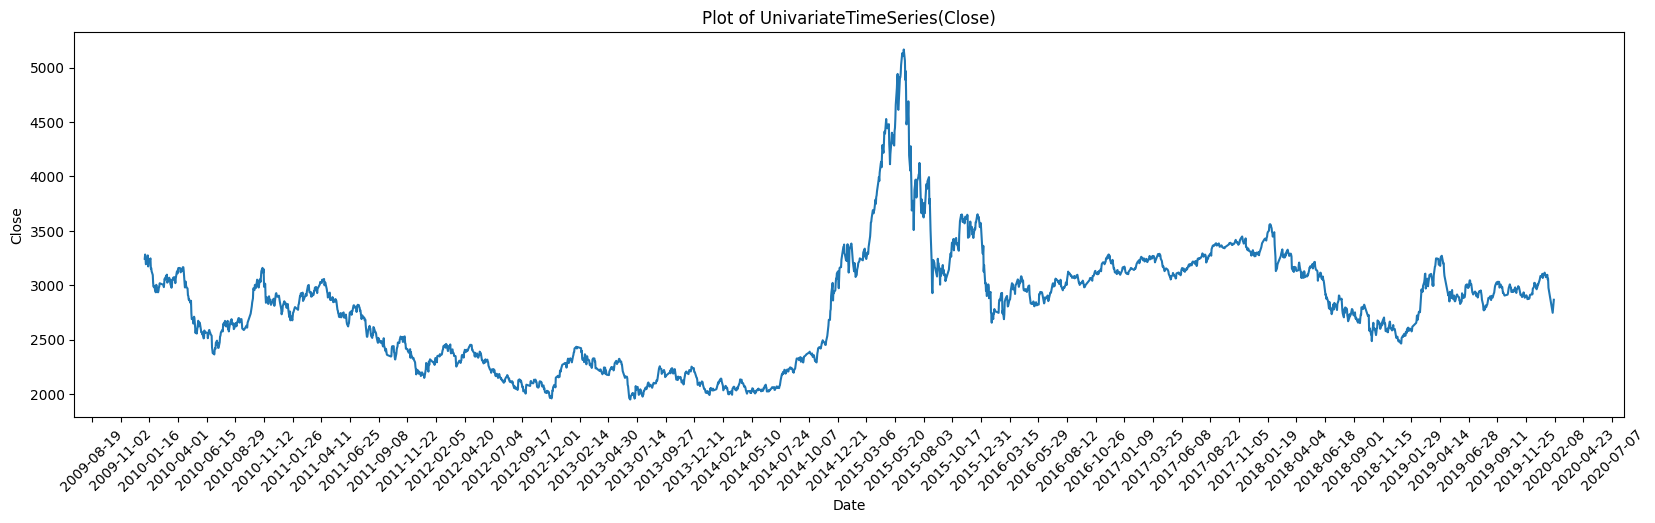

In [7]:
stock_of_interest.plot(tick_skip=75)

### Get Descriptive Statistics of Raw Data

In [9]:
stock_of_interest.get_statistics(time_type="Days", stock_data=True)

/Users/detraviousjamaribrinkley/Documents/Development/self/applied_time_series_and_machine_learning/framework_for_time_series_data/nlp_ts/../tslearn/time_series.py:194: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  count_value = int(stats.loc['count'])


,Close
total Days,2447.0
most recent date,2015-06-12 00:00:00
inception date,2013-06-27 00:00:00
lowest price,1950.01
highest price,5166.35
average price,2801.36
range,3216.34
price volatility,529.3
25th percentile price,2346.35
median price,2859.76


In [10]:
stock_of_interest.range_skewness_kurtosis()

{'range': Close    3216.34
 dtype: float64,
 'skewness': Close    0.748993
 dtype: float64,
 'kurtosis': Close    1.537912
 dtype: float64}

### Check Stationarity of Raw Data

- With financial data, we expect it to be non-stationary (as in there's a change in either or both the mean of the variance between two distant points).

In [11]:
stock_of_interest.stationarity_test(stock_df)

ADF Statistic: -2.226796
p-value: 0.196664 > 0.05 , so accept the null-hypothesis as the TS is non-stationary
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


### Plot Autocorrelation and Partial Autocorrelation of Raw Data

- Not required for `AR` or `ARMA` models as both models assumes stationary and the TS is non-stationary.

/Users/detraviousjamaribrinkley/Documents/Development/self/applied_time_series_and_machine_learning/framework_for_time_series_data/nlp_ts/../tslearn/time_series.py:400: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return self.variance()[0]
/Users/detraviousjamaribrinkley/Documents/Development/self/applied_time_series_and_machine_learning/framework_for_time_series_data/nlp_ts/../tslearn/time_series.py:401: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  mean = self.mean()[0]
/Users/detraviousjamaribrinkley/Documents/Development/self/applied_time_series_and_machine_learning/framework_for_time_series_data/nlp_ts/../tslea

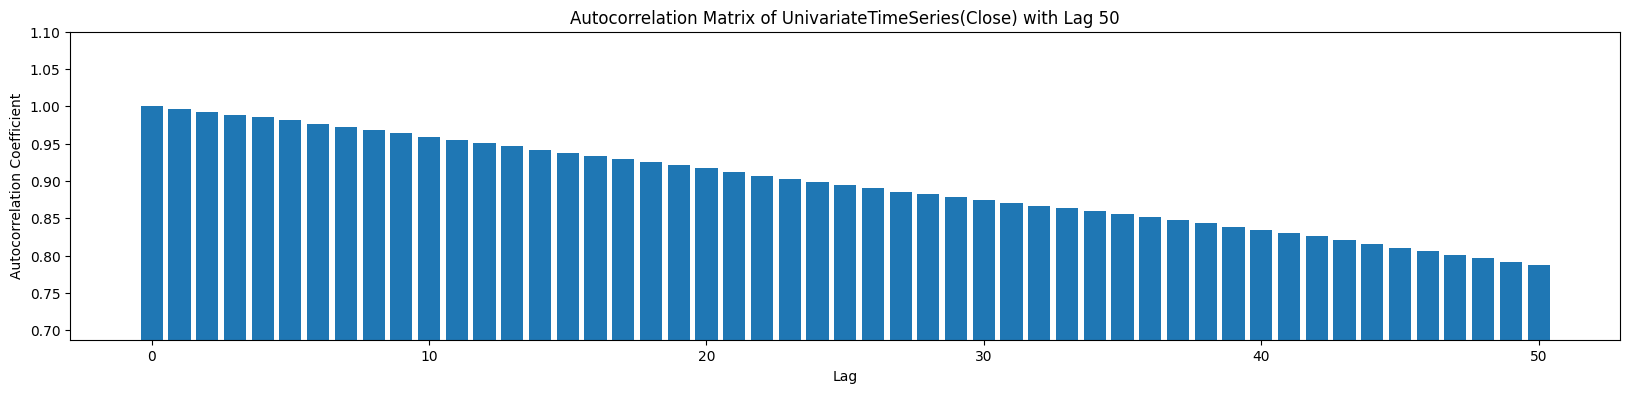

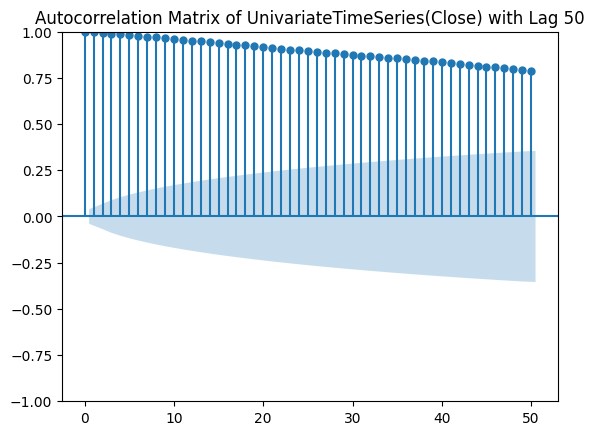

In [12]:
stock_of_interest.plot_autocorrelation(50)

- What is the above telling us?
    - Both plots are the same, just showing differently. 
    - Both plots confirm that the TS is non-stationary as in the current value depends on the previous value. We don't want this with traditional TS models like `AR`, `ARMA`.

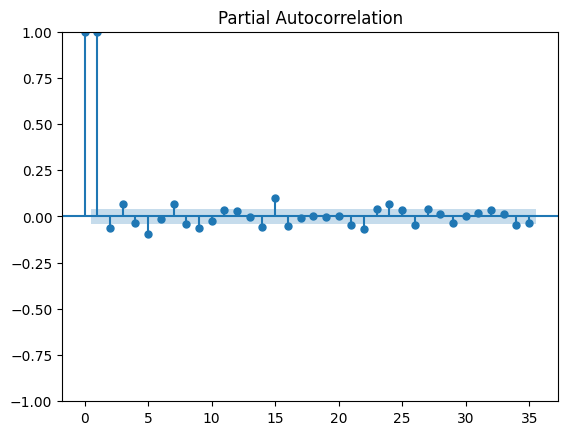

In [13]:
stock_of_interest.plot_partial_autocorrelation(35)

- What is the above telling us?
    - TS is non-stationary. Although data isn't as dependent (like the ACorr plot), the 1st is dependent upon the 0th. 

### Split Raw Data for RW Model

- Make 5-day forecasts

In [14]:
interpolate_step = 5
N = len(stock_of_interest.get_series())
train_length = N - interpolate_step

In [15]:
train_uts, test_uts = stock_of_interest.get_slice(1, train_length, both_train_test=True)
train_uts, test_uts

1 2442


(UnivariateTimeSeries(UnivariateTimeSeries(Close)[1:2442]),
 UnivariateTimeSeries(UnivariateTimeSeries(Close)[2442:2447]))

In [16]:
train_df = train_uts.get_as_df()
train_df

,UnivariateTimeSeries(Close)[1:2442]
Date,
2010-01-05,3282.178955
2010-01-06,3254.215088
2010-01-07,3192.775879
2010-01-08,3195.997070
2010-01-11,3212.750000
...,...
2020-01-16,3074.081055
2020-01-17,3075.496094
2020-01-20,3095.787109


- Make 5-day forecasts, hence why test data is only 5 values.

In [17]:
test_df = test_uts.get_as_df()
test_df

,UnivariateTimeSeries(Close)[2442:2447]
Date,
2020-01-23,2976.528076
2020-02-03,2746.605957
2020-02-04,2783.288086
2020-02-05,2818.087891
2020-02-06,2866.510010


### RW

In [18]:
rw_model_class = RandomWalk()

rw_interpolate_predictions = rw_model_class.predict(train_df, test_df)

TypeError: Model.__init__() missing 1 required positional argument: 'train_type_name'

In [19]:
type(rw_interpolate_predictions[0]), len(rw_interpolate_predictions), rw_interpolate_predictions

NameError: name 'rw_interpolate_predictions' is not defined

In [20]:
rw_mse_gsts = EvaluationMetric.eval_mse(test_df, rw_interpolate_predictions, per_element=False)
rw_rmse_gsts = EvaluationMetric.eval_rmse(test_df, rw_interpolate_predictions, per_element=False)

NameError: name 'rw_interpolate_predictions' is not defined

### Split Differenced Data for ARMA(p, q) Model

- Make 5-day forecasts

In [21]:
forecasting_step = 5
N = len(stock_returns.get_series())
diff_train_length = N - forecasting_step

NameError: name 'stock_returns' is not defined

In [22]:
diff_train_uts, diff_test_uts = stock_returns.get_slice(1, diff_train_length, both_train_test=True)
diff_train_uts, diff_test_uts

NameError: name 'stock_returns' is not defined

In [23]:
diff_train_df = diff_train_uts.get_as_df()
diff_train_df

NameError: name 'diff_train_uts' is not defined

- Make 5-day forecasts, hence why test data is only 5 values.

In [24]:
diff_test_df = diff_test_uts.get_as_df()
diff_test_df

NameError: name 'diff_test_uts' is not defined

In [25]:
lag_p = 1
error_q = 1

arma_model_class = ARMA()
arma_model = arma_model_class.train_arma_model(diff_train_df, lag_p, error_q)

TypeError: Model.__init__() missing 1 required positional argument: 'train_type_name'

In [26]:
trained_arma_model = arma_model_class.train_arma_model(diff_train_df, lag_p, error_q)
trained_arma_model

NameError: name 'arma_model_class' is not defined

In [27]:
trained_arma_model.summary()

NameError: name 'trained_arma_model' is not defined

In [28]:
print('Coefficients: %s' % trained_arma_model.params)

NameError: name 'trained_arma_model' is not defined

NOTE: Should Dep. Variable be t as t depends on t - 1?

In [29]:
# retrain false
arma_predictions_no_retrain = arma_model_class.predict(arma_model, diff_train_df, diff_test_df, False, lag_p)

# retrain true
arma_predictions_retrain = arma_model_class.predict(arma_model, diff_train_df, diff_test_df, True, lag_p)

NameError: name 'arma_model_class' is not defined

In [30]:
len(diff_test_df), len(arma_predictions_no_retrain), len(arma_predictions_retrain)

NameError: name 'diff_test_df' is not defined

### Predict + Plot Actual Forecasts vs Predicted Forecasts for Raw Data

In [31]:
arma_mse_no_retrain = EvaluationMetric.eval_mse(diff_test_df, arma_predictions_no_retrain, per_element=False)
arma_rmse_no_retrain = EvaluationMetric.eval_rmse(diff_test_df, arma_predictions_no_retrain, per_element=False)

arma_mse_retrain = EvaluationMetric.eval_mse(diff_test_df, arma_predictions_retrain, per_element=False)
arma_rmse_retrain = EvaluationMetric.eval_rmse(diff_test_df, arma_predictions_retrain, per_element=False)

NameError: name 'diff_test_df' is not defined

In [32]:
EvaluationMetric.plot_forecast(diff_train_df, diff_test_df, arma_predictions_no_retrain, False)
EvaluationMetric.plot_forecast(diff_train_df, diff_test_df, arma_predictions_retrain, False)
EvaluationMetric.plot_predictions(diff_test_df, arma_predictions_no_retrain)
EvaluationMetric.plot_predictions(diff_test_df, arma_predictions_retrain)

AttributeError: type object 'EvaluationMetric' has no attribute 'plot_forecast'

### Train Test Split Returns Data for ML Models

- 80% train and 20% test
- Return DF for now and fix later.

In [ ]:
prior_observations =  3 
forecasting_step = 2
X_train_df, y_train_df = stock_of_interest.augment_data(prior_observations, forecasting_step)

In [ ]:
# X_train_df

In [ ]:
# y_train_df

In [ ]:
reformatted_returns_df = stock_of_interest.split_sequence(forecasting_step, prior_observations)
reformatted_returns_df

In [ ]:
X = reformatted_returns_df['t-1']
X

In [ ]:
y = reformatted_returns_df['t']
y

In [ ]:
X_train, X_test, y_train, y_test = TimeSeriesMixin.get_train_validation_test_split(X, y, test_size=0.2)

In [ ]:
len(X_train), len(X_test), len(y_train), len(y_test)

In [ ]:
X_train

In [ ]:
y_train